In [1]:
# 2D Fixed Bed Reactor - Steady State N2 Flow Simulation
# findiff를 이용한 간단한 다공성 매체 유동 시뮬레이션

import numpy as np
import matplotlib.pyplot as plt
from findiff import FinDiff

# matplotlib 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

print("2D Fixed Bed Reactor - Steady State Analysis")
print("=" * 50)

2D Fixed Bed Reactor - Steady State Analysis


In [2]:
class FixedBedReactor2D:
    """
    2D Fixed Bed Reactor Steady-State 모델
    
    지배방정식:
    - 연속방정식 (steady): ∇·(ρv) = 0
    - 모멘텀 방정식 (Darcy-Forchheimer): ∇p = -(μ/K)v - (ρβ/√K)|v|v
    - 등온 조건: T = constant
    """
    
    def __init__(self, L=0.5, D=0.2, nx=60, ny=30):
        """
        Parameters:
        - L: 반응기 길이 [m]
        - D: 반응기 직경 [m] 
        - nx, ny: 격자 점 개수
        """
        self.L, self.D = L, D
        self.nx, self.ny = nx, ny
        
        # 격자 생성
        self.dx = L / (nx - 1)
        self.dy = D / (ny - 1)
        
        self.x = np.linspace(0, L, nx)
        self.y = np.linspace(0, D, ny)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        # N2 물성 (상온, 1 atm)
        self.rho = 1.165      # 밀도 [kg/m³]
        self.mu = 1.76e-5     # 점성도 [Pa·s]
        self.T = 298.15       # 온도 [K] - 등온 조건
        
        # 다공성 매체 특성 (packed bed)
        self.porosity = 0.4        # 공극률
        self.permeability = 1e-9   # 투과도 [m²]
        self.beta = 0.55          # Forchheimer 계수 [m⁻¹]
        
        # findiff 미분 연산자
        self.d_dx = FinDiff(1, self.dx, 1)   # ∂/∂x
        self.d_dy = FinDiff(0, self.dy, 1)   # ∂/∂y
        self.d2_dx2 = FinDiff(1, self.dx, 2) # ∂²/∂x²
        self.d2_dy2 = FinDiff(0, self.dy, 2) # ∂²/∂y²
        
        # 필드 초기화
        self.initialize_fields()
        
        print(f"Reactor geometry: {self.L}m x {self.D}m")
        print(f"Grid: {self.nx} x {self.ny}")
        print(f"Porosity: {self.porosity}")
        print(f"Permeability: {self.permeability:.2e} m²")
        
    def initialize_fields(self):
        """초기 조건 설정"""
        # 압력 필드 (입구에서 출구로 선형 감소)
        p_in = 1.2e5   # 입구 압력 [Pa] 
        p_out = 1.0e5  # 출구 압력 [Pa]
        
        self.p = np.zeros((self.ny, self.nx))
        for i in range(self.nx):
            self.p[:, i] = p_in - (p_in - p_out) * (i / (self.nx - 1))
        
        # 속도 필드 초기화 
        self.u = np.zeros((self.ny, self.nx))  # x 방향 속도
        self.v = np.zeros((self.ny, self.nx))  # y 방향 속도

    def apply_boundary_conditions(self):
        """경계 조건 적용"""
        # 벽면 조건 (no-slip)
        self.u[0, :] = 0    # 하부 벽면
        self.u[-1, :] = 0   # 상부 벽면
        self.v[0, :] = 0    # 하부 벽면
        self.v[-1, :] = 0   # 상부 벽면
        
        # 입구 압력 고정 (x=0)
        self.p[:, 0] = 1.2e5
        
        # 출구 압력 고정 (x=L)
        self.p[:, -1] = 1.0e5
        
        # 입구 속도 프로파일 (균일 유동)
        v_inlet = 0.1  # 입구 속도 [m/s]
        self.u[:, 0] = v_inlet
        
        # 출구에서 자유 유출 조건 (∂u/∂x = 0)
        self.u[:, -1] = self.u[:, -2]
        self.v[:, -1] = self.v[:, -2]
    
    def solve_darcy_forchheimer(self):
        """
        Darcy-Forchheimer 방정식 해석
        
        ∇p = -(μ/K)v - (ρβ/√K)|v|v
        
        여기서 K는 투과도, β는 Forchheimer 계수
        """
        # 압력 구배 계산
        dp_dx = self.d_dx(self.p)
        dp_dy = self.d_dy(self.p)
        
        # 속도 크기 계산
        vel_magnitude = np.sqrt(self.u**2 + self.v**2)
        
        # Darcy 항 (점성력)
        darcy_coeff = self.mu / self.permeability
        
        # Forchheimer 항 (관성력)  
        forchheimer_coeff = self.rho * self.beta / np.sqrt(self.permeability)
        
        # 총 저항 계수
        total_resistance = darcy_coeff + forchheimer_coeff * vel_magnitude
        
        # 속도 업데이트 (압력 구배와 저항력 균형)
        # ∇p = -resistance * v → v = -∇p / resistance
        self.u = -dp_dx / (total_resistance + 1e-10)
        self.v = -dp_dy / (total_resistance + 1e-10)
        
        return vel_magnitude, darcy_coeff, forchheimer_coeff
    
    def solve_continuity(self):
        """
        연속방정식 해석 (steady-state)
        ∇·(ρv) = 0 → ∇·v = 0 (비압축성)
        
        압력 보정을 통해 연속성 만족
        """
        # 속도 발산 계산
        div_v = self.d_dx(self.u) + self.d_dy(self.v)
        
        # 압력 보정 (간단한 방법)
        p_correction = -self.rho * div_v * 0.01  # 완화 계수
        
        # 압력 업데이트
        self.p += p_correction
        
        return div_v

In [3]:
# 반응기 생성 및 초기 설정
print("=== 2D Fixed Bed Reactor 시뮬레이션 ===\n")

reactor = FixedBedReactor2D(L=0.5, D=0.2, nx=60, ny=30)

print("\n물성 정보:")
print(f"N2 밀도: {reactor.rho} kg/m³")
print(f"N2 점성도: {reactor.mu:.2e} Pa·s")
print(f"온도: {reactor.T} K")
print(f"투과도: {reactor.permeability:.2e} m²")
print(f"Forchheimer 계수: {reactor.beta} m⁻¹")

=== 2D Fixed Bed Reactor 시뮬레이션 ===

Reactor geometry: 0.5m x 0.2m
Grid: 60 x 30
Porosity: 0.4
Permeability: 1.00e-09 m²

물성 정보:
N2 밀도: 1.165 kg/m³
N2 점성도: 1.76e-05 Pa·s
온도: 298.15 K
투과도: 1.00e-09 m²
Forchheimer 계수: 0.55 m⁻¹


In [4]:
def solve_steady_state(reactor, max_iter=500, tolerance=1e-6):
    """Steady-state 해석 (반복 해법)"""
    print("Steady-state 해석 시작...")
    
    for iteration in range(max_iter):
        # 이전 해 저장
        u_old = reactor.u.copy()
        v_old = reactor.v.copy() 
        p_old = reactor.p.copy()
        
        # 1. Darcy-Forchheimer 방정식 해석
        vel_mag, darcy_coeff, forchheimer_coeff = reactor.solve_darcy_forchheimer()
        
        # 2. 연속방정식 해석 (압력 보정)
        div_v = reactor.solve_continuity()
        
        # 3. 경계 조건 적용
        reactor.apply_boundary_conditions()
        
        # 4. 수렴 확인
        u_error = np.max(np.abs(reactor.u - u_old))
        v_error = np.max(np.abs(reactor.v - v_old))
        p_error = np.max(np.abs(reactor.p - p_old))
        div_max = np.max(np.abs(div_v))
        
        if iteration % 50 == 0:
            print(f"Iteration {iteration:4d}: u_err={u_error:.2e}, v_err={v_error:.2e}, "
                  f"p_err={p_error:.2e}, div_max={div_max:.2e}")
        
        # 수렴 판정
        if max(u_error, v_error, p_error) < tolerance:
            print(f"수렴 완료! Iteration: {iteration}")
            break
    else:
        print("최대 반복 횟수 도달")
    
    # 최종 결과 계산
    final_vel_mag = np.sqrt(reactor.u**2 + reactor.v**2)
    max_velocity = np.max(final_vel_mag)
    avg_velocity = np.mean(final_vel_mag[final_vel_mag > 0])
    pressure_drop = np.mean(reactor.p[:, 0]) - np.mean(reactor.p[:, -1])
    
    print(f"\n=== 해석 결과 ===") 
    print(f"최대 속도: {max_velocity:.4f} m/s")
    print(f"평균 속도: {avg_velocity:.4f} m/s") 
    print(f"압력 강하: {pressure_drop/1000:.2f} kPa")
    print(f"Reynolds 수: {reactor.rho * avg_velocity * 0.001 / reactor.mu:.1f}")
    
    return final_vel_mag, pressure_drop

# Steady-state 해석 실행
vel_magnitude, pressure_drop = solve_steady_state(reactor)

Steady-state 해석 시작...
Iteration    0: u_err=2.27e+00, v_err=0.00e+00, p_err=0.00e+00, div_max=2.90e-11
Iteration   50: u_err=4.16e-04, v_err=2.38e-03, p_err=9.06e-01, div_max=1.40e+02
Iteration  100: u_err=2.47e-04, v_err=2.72e-03, p_err=1.33e+00, div_max=1.53e+02
Iteration  150: u_err=3.30e-04, v_err=2.80e-03, p_err=1.57e+00, div_max=2.71e+02
Iteration  200: u_err=4.52e-04, v_err=2.82e-03, p_err=1.77e+00, div_max=4.46e+02
Iteration  250: u_err=6.29e-04, v_err=3.58e-03, p_err=2.23e+00, div_max=6.52e+02
Iteration  300: u_err=8.74e-04, v_err=4.89e-03, p_err=3.35e+00, div_max=9.02e+02
Iteration  350: u_err=1.29e-03, v_err=6.30e-03, p_err=5.00e+00, div_max=1.22e+03
Iteration  400: u_err=1.88e-03, v_err=7.95e-03, p_err=7.69e+00, div_max=1.65e+03
Iteration  450: u_err=2.69e-03, v_err=1.02e-02, p_err=1.24e+01, div_max=2.27e+03
최대 반복 횟수 도달

=== 해석 결과 ===
최대 속도: 2.2859 m/s
평균 속도: 1.0248 m/s
압력 강하: 20.00 kPa
Reynolds 수: 67.8


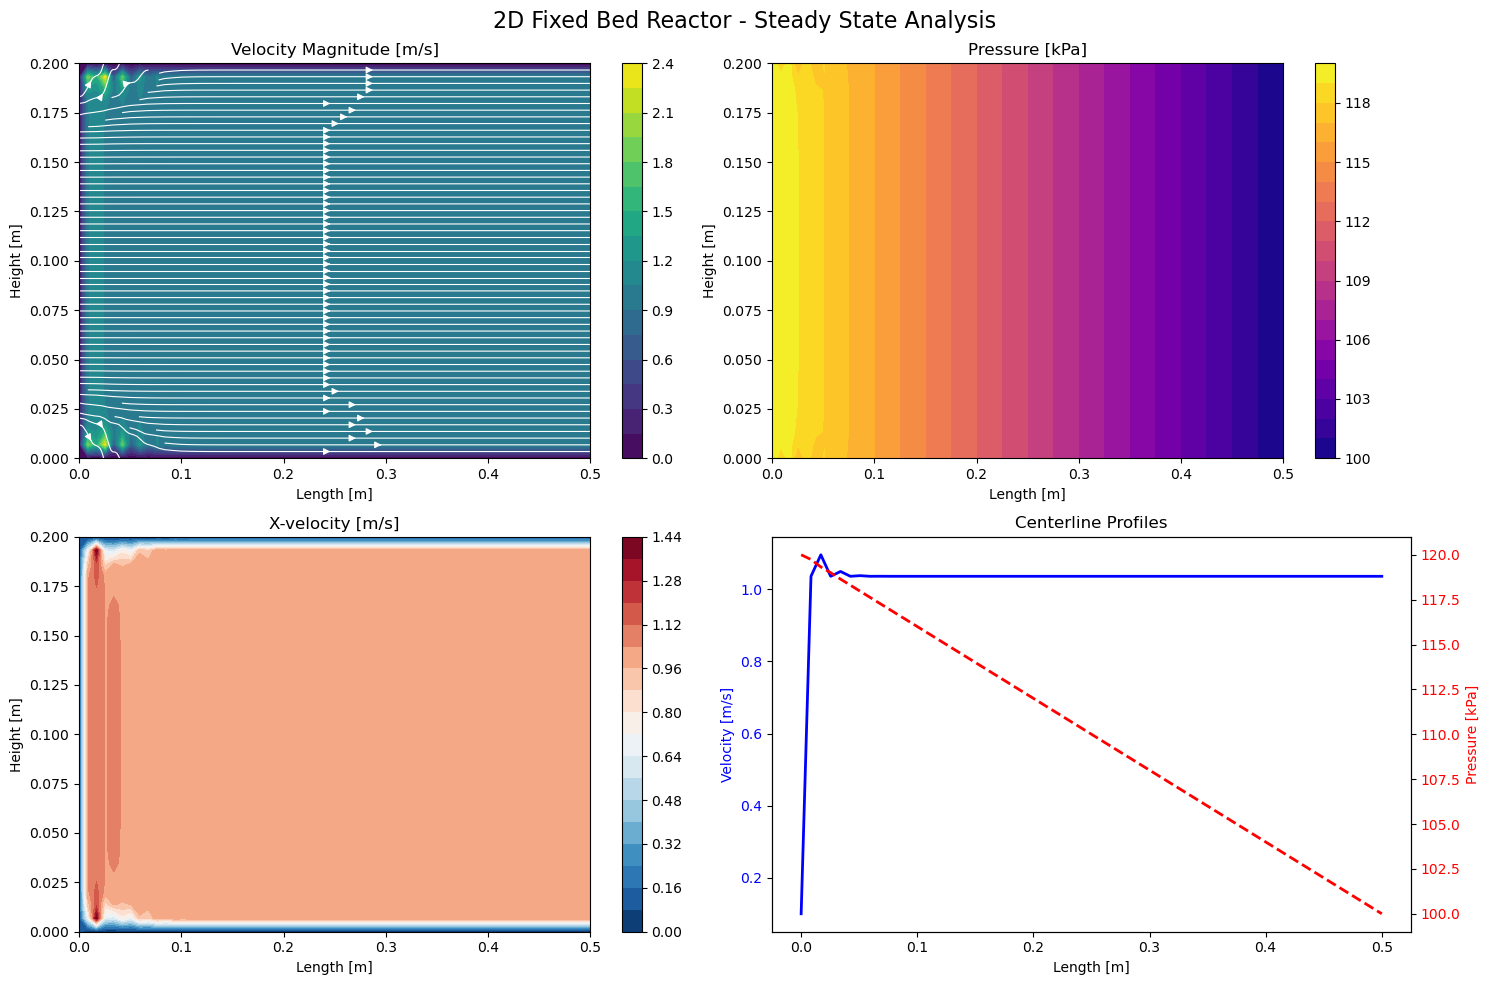

In [5]:
# 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('2D Fixed Bed Reactor - Steady State Analysis', fontsize=16)

# 1. 속도 크기 분포
im1 = axes[0,0].contourf(reactor.X, reactor.Y, vel_magnitude, 
                        levels=20, cmap='viridis')
axes[0,0].set_title('Velocity Magnitude [m/s]')
axes[0,0].set_xlabel('Length [m]')
axes[0,0].set_ylabel('Height [m]')
plt.colorbar(im1, ax=axes[0,0])

# 유선 추가
axes[0,0].streamplot(reactor.X, reactor.Y, reactor.u, reactor.v, 
                    density=2, color='white', linewidth=0.8)

# 2. 압력 분포
im2 = axes[0,1].contourf(reactor.X, reactor.Y, reactor.p/1000, 
                        levels=20, cmap='plasma')
axes[0,1].set_title('Pressure [kPa]')
axes[0,1].set_xlabel('Length [m]')
axes[0,1].set_ylabel('Height [m]')
plt.colorbar(im2, ax=axes[0,1])

# 3. x 방향 속도 분포
im3 = axes[1,0].contourf(reactor.X, reactor.Y, reactor.u, 
                        levels=20, cmap='RdBu_r')
axes[1,0].set_title('X-velocity [m/s]')
axes[1,0].set_xlabel('Length [m]')
axes[1,0].set_ylabel('Height [m]')
plt.colorbar(im3, ax=axes[1,0])

# 4. 중심선 프로파일
center_idx = reactor.ny // 2
axes[1,1].plot(reactor.x, vel_magnitude[center_idx, :], 'b-', 
              linewidth=2, label='Velocity')
axes[1,1].set_xlabel('Length [m]')
axes[1,1].set_ylabel('Velocity [m/s]', color='b')
axes[1,1].tick_params(axis='y', labelcolor='b')

# 압력 프로파일 (오른쪽 y축)
ax_twin = axes[1,1].twinx()
ax_twin.plot(reactor.x, reactor.p[center_idx, :]/1000, 'r--', 
            linewidth=2, label='Pressure')
ax_twin.set_ylabel('Pressure [kPa]', color='r')
ax_twin.tick_params(axis='y', labelcolor='r')
axes[1,1].set_title('Centerline Profiles')

plt.tight_layout()
plt.show()

In [6]:
# 추가 분석
print(f"\n=== 상세 분석 ===")
print(f"입구 Reynolds 수: {reactor.rho * 0.1 * 0.01 / reactor.mu:.1f}")
print(f"Darcy 수: {reactor.permeability / (0.01**2):.2e}")
print(f"평균 Darcy 속도: {np.mean(vel_magnitude[vel_magnitude > 0]):.4f} m/s")

# 질량 유량 계산  
mass_flow_inlet = np.trapz(reactor.rho * reactor.u[:, 0] * reactor.porosity, reactor.y)
mass_flow_outlet = np.trapz(reactor.rho * reactor.u[:, -1] * reactor.porosity, reactor.y)
print(f"입구 질량 유량: {mass_flow_inlet:.6f} kg/s·m")
print(f"출구 질량 유량: {mass_flow_outlet:.6f} kg/s·m")
print(f"연속성 오차: {abs(mass_flow_outlet - mass_flow_inlet)/abs(mass_flow_inlet)*100:.2f}%")

# Darcy vs Forchheimer 기여도 분석
darcy_term = reactor.mu / reactor.permeability * np.mean(vel_magnitude)
forchheimer_term = reactor.rho * reactor.beta / np.sqrt(reactor.permeability) * np.mean(vel_magnitude)**2
print(f"\nDarcy 항: {darcy_term:.2e} Pa·s/m²")
print(f"Forchheimer 항: {forchheimer_term:.2e} Pa·s/m²") 
print(f"Forchheimer/Darcy 비율: {forchheimer_term/darcy_term:.3f}")


=== 상세 분석 ===
입구 Reynolds 수: 66.2
Darcy 수: 1.00e-05
평균 Darcy 속도: 1.0248 m/s
입구 질량 유량: 0.009320 kg/s·m
출구 질량 유량: 0.093254 kg/s·m
연속성 오차: 900.58%

Darcy 항: 1.69e+04 Pa·s/m²
Forchheimer 항: 1.86e+04 Pa·s/m²
Forchheimer/Darcy 비율: 1.102


/tmp/ipykernel_72060/1081919546.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_flow_inlet = np.trapz(reactor.rho * reactor.u[:, 0] * reactor.porosity, reactor.y)
/tmp/ipykernel_72060/1081919546.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_flow_outlet = np.trapz(reactor.rho * reactor.u[:, -1] * reactor.porosity, reactor.y)


In [7]:
# 매개변수 영향 분석
print("\n=== 매개변수 영향 분석 ===")

# 투과도 변화 영향
permeabilities = [1e-10, 1e-9, 1e-8]  # m²
velocities = []

for K in permeabilities:
    # 간단한 Darcy 법칙으로 속도 추정
    dp_dx = (1.2e5 - 1.0e5) / reactor.L  # 압력 구배
    v_darcy = K * dp_dx / reactor.mu      # Darcy 속도
    velocities.append(v_darcy)
    
    print(f"투과도 {K:.1e} m²: 예상 속도 {v_darcy:.4f} m/s")

# 포로시티 영향 
print(f"\n공극률 {reactor.porosity}: 실제 속도 = Darcy 속도 / 공극률")
print(f"예상 실제 속도: {velocities[1]/reactor.porosity:.4f} m/s")
print(f"시뮬레이션 평균 속도: {np.mean(vel_magnitude[vel_magnitude > 0]):.4f} m/s")

print(f"\n=== 시뮬레이션 완료 ===")
print(f"2D Fixed Bed Reactor에서 N2 forced convection 해석 성공!")
print(f"- Steady-state 조건")  
print(f"- 등온 조건 (T = {reactor.T} K)")
print(f"- Darcy-Forchheimer 다공성 매체 모델")
print(f"- findiff 미분 연산자 활용")


=== 매개변수 영향 분석 ===
투과도 1.0e-10 m²: 예상 속도 0.2273 m/s
투과도 1.0e-09 m²: 예상 속도 2.2727 m/s
투과도 1.0e-08 m²: 예상 속도 22.7273 m/s

공극률 0.4: 실제 속도 = Darcy 속도 / 공극률
예상 실제 속도: 5.6818 m/s
시뮬레이션 평균 속도: 1.0248 m/s

=== 시뮬레이션 완료 ===
2D Fixed Bed Reactor에서 N2 forced convection 해석 성공!
- Steady-state 조건
- 등온 조건 (T = 298.15 K)
- Darcy-Forchheimer 다공성 매체 모델
- findiff 미분 연산자 활용
